# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [3]:
df=pd.read_csv('../data/checker_submits.csv')

df['hour']=pd.DatetimeIndex(df['timestamp']).hour
df['dayofweek']=pd.DatetimeIndex(df['timestamp']).weekday
df.drop(columns='timestamp', inplace=True)
df.head()

,uid,labname,numTrials,hour,dayofweek
0,user_4,project1,1,5,4
1,user_4,project1,2,5,4
2,user_4,project1,3,5,4
3,user_4,project1,4,5,4
4,user_4,project1,5,5,4


In [4]:
encoder=OneHotEncoder(sparse_output=False)
encoded_d=encoder.fit_transform(df[['labname','uid']])
labels=encoder.get_feature_names_out(['labname','uid'])
encoded_df=pd.DataFrame(encoded_d, columns=labels)
df2=pd.concat([df,encoded_df], axis=1)
res_df=df2.drop(columns=['uid','labname'])
res_df.head()

,numTrials,hour,dayofweek,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8
0,1,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
scaler=StandardScaler()
res_df[['numTrials','hour']]=scaler.fit_transform(res_df[['numTrials','hour']])
res_df

,numTrials,hour,dayofweek,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8
0,-0.788667,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.756764,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.724861,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.692958,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.661055,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,-0.629151,0.945382,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1683,-0.597248,0.945382,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1684,-0.565345,0.945382,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
res_df.to_csv('../data/dayofweek.csv',index=False)

In [7]:
y=res_df['dayofweek']
moda=int(y.mode()[0])
naive=[moda]*len(y)
acc_naive=accuracy_score(y, naive)
acc_naive

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [8]:
x=res_df.drop(columns='dayofweek',axis=1)  #we deleted it for x because we will predict it
y=res_df['dayofweek']
lr=LogisticRegression(random_state=21, fit_intercept=False)
lr.fit(x,y)

LogisticRegression(fit_intercept=False, random_state=21)

In [9]:
lr_predict=lr.predict(x)
acc_lr=accuracy_score(y, lr_predict)
acc_lr

0.6405693950177936

In [10]:
def top_n_features(coef, names_of_features, n=10):
    
    importance=np.abs(coef)
    sorted_indices=np.argsort(importance)[-n:]
    top_n=[names_of_features[i] for i in sorted_indices]
    top_import=importance[sorted_indices]
    plt.figure(figsize=(15, 8))
    plt.barh(range(n), top_import, color='c', align='center')
    plt.yticks(range(n), top_n)
    plt.title(f'top-{n} most important features')
    plt.show()
    

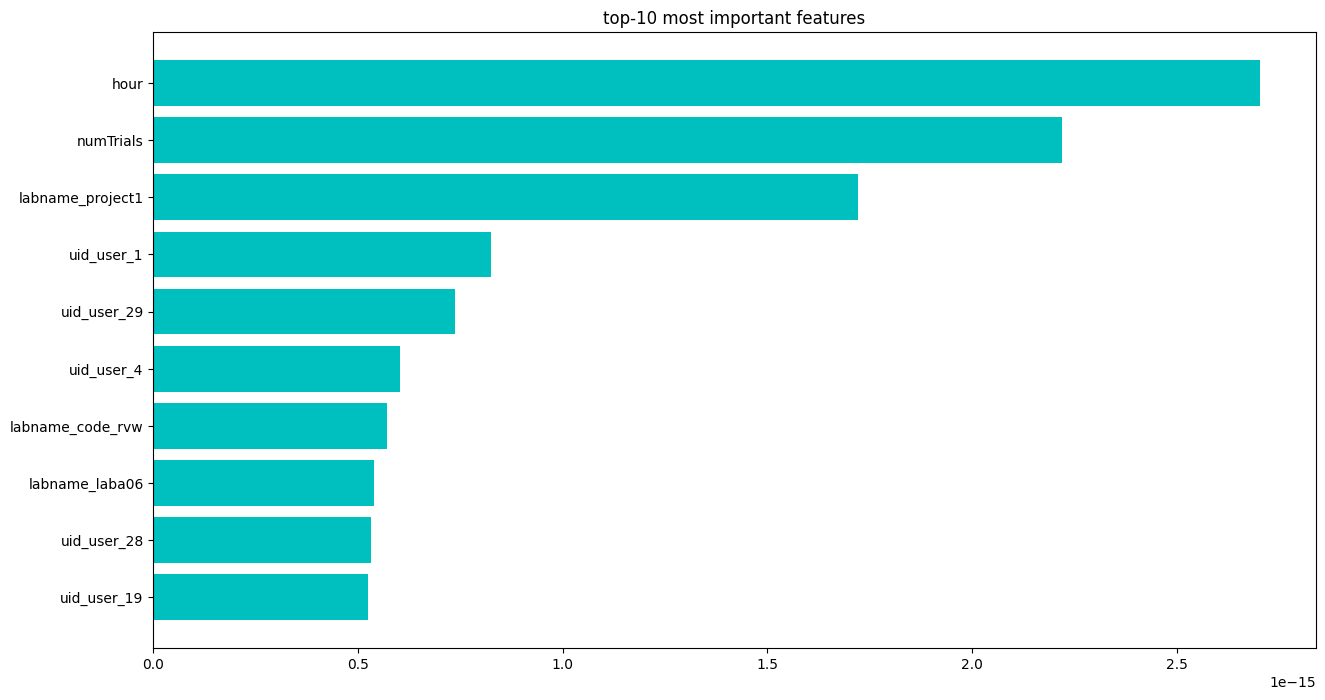

In [11]:
feat_names=x.columns
top_n_features(lr.coef_.mean(axis=0), feat_names)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [12]:
svc=SVC(kernel='linear',probability=True, random_state=21)
svc.fit(x,y)

SVC(kernel='linear', probability=True, random_state=21)

In [13]:
svc_predict=svc.predict(x)
acc_svc=accuracy_score(y, svc_predict)
acc_svc

0.702846975088968

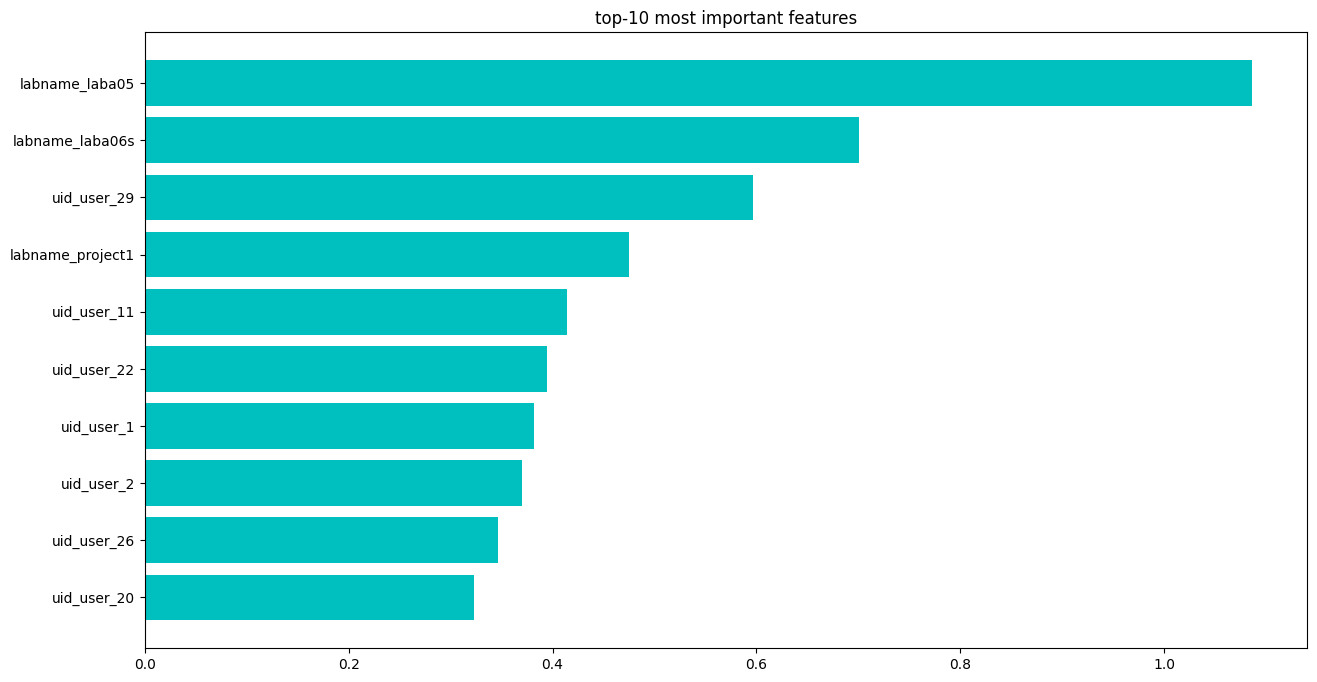

In [14]:
top_n_features(svc.coef_.mean(axis=0), feat_names)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [15]:
tree = DecisionTreeClassifier(random_state=42, max_depth=4)
tree.fit(x, y)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [16]:
tree_predict=tree.predict(x)
acc_tree=accuracy_score(y, tree_predict)
acc_tree

0.5516014234875445

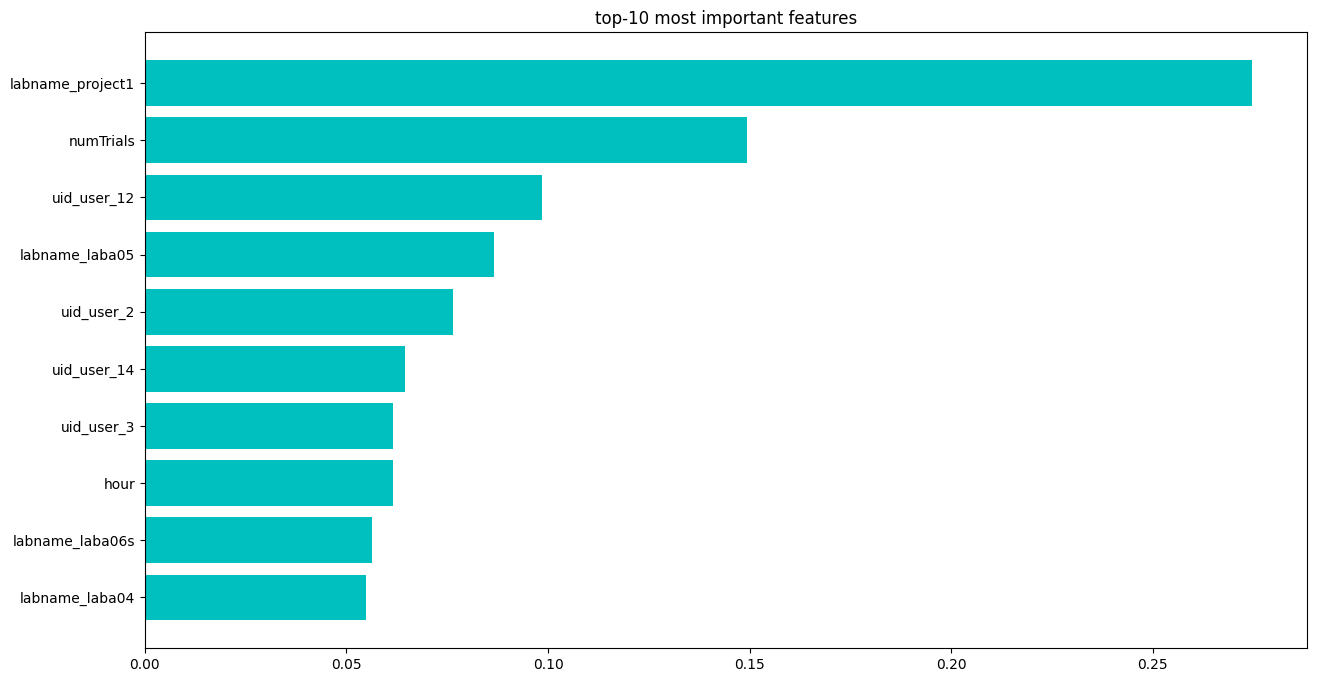

In [17]:
top_n_features(tree.feature_importances_, feat_names)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [18]:
forest=RandomForestClassifier(n_estimators=100, random_state=21, max_depth=25)
forest.fit(x,y)


RandomForestClassifier(max_depth=25, random_state=21)

In [19]:
forest_predict=forest.predict(x)
acc_forest=accuracy_score(y, forest_predict)
acc_forest

1.0

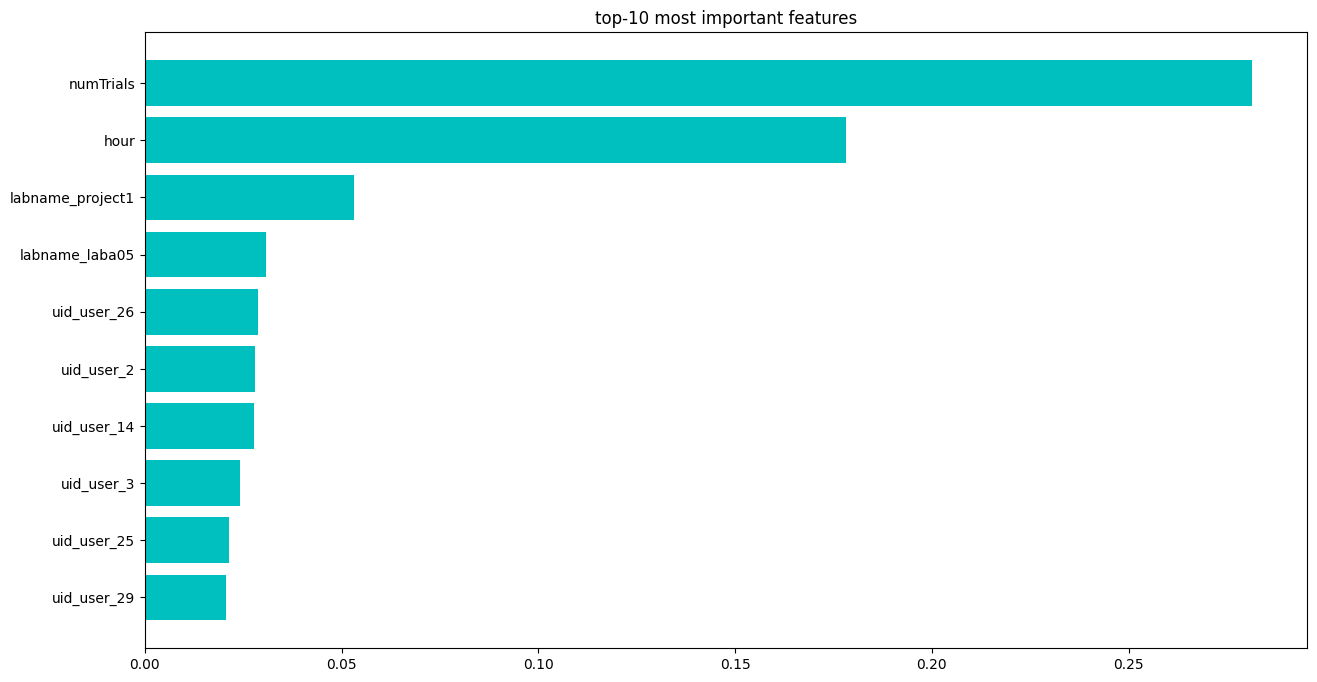

In [20]:
top_n_features(forest.feature_importances_, feat_names)